# LTSM 1 NOTEBOOK
The primary purpose of this  notebook is to build and test and LSTM model, based off of the first round of data cleaning, that aims to predict wholesale and retail prices of maize in various markets. 

the data to be used will undergo a little bit of featured engineering and we will be working with nearly the same columns as those in the original data source

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [2]:
data = pd.read_csv("modeling_data.csv")

In [3]:
data.head()

,Classification,Market,Wholesale,Retail,Supply Volume,County,Date,Market_Ahero,Market_Akala,Market_Amoni,...,County_Taita-Taveta,County_Tana-River,County_Tharaka-Nithi,County_Trans-Nzoia,County_Turkana,County_Uasin-Gishu,County_Vihiga,County_Wajir,County_West-Pokot,County_test
0,Mixed-Traditional,Isebania Market,22.578,32.0,45000.0,Migori,2024-08-27,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,White Maize,Ahero,45.000,50.0,7000.0,Kisumu,2024-08-27,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,White Maize,Nyamakima,44.440,70.0,5860.0,Nairobi,2024-08-27,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,White Maize,Kathonzweni,35.000,40.0,7200.0,Makueni,2024-08-27,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,White Maize,Kawangware,40.000,50.0,6544.0,Nairobi,2024-08-27,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21257 entries, 0 to 21256
Columns: 297 entries, Classification to County_test
dtypes: float64(293), object(4)
memory usage: 48.2+ MB


In [5]:
#converting date values to a more cyclical way of representatiom
data['Date'] = pd.to_datetime(data['Date'])

# Extract numerical features from 'Date'
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

# Add cyclical transformations for 'Day' and 'Month'
data['Day_sin'] = np.sin(2 * np.pi * data['Day'] / 31)
data['Day_cos'] = np.cos(2 * np.pi * data['Day'] / 31)
data['Month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
data['Month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)


min_year = data['Year'].min()
max_year = data['Year'].max()
data['Year_sin'] = np.sin(2 * np.pi * (data['Year'] - min_year) / (max_year - min_year + 1))
data['Year_cos'] = np.cos(2 * np.pi * (data['Year'] - min_year) / (max_year - min_year + 1))


In [6]:
data.head()

,Classification,Market,Wholesale,Retail,Supply Volume,County,Date,Market_Ahero,Market_Akala,Market_Amoni,...,County_test,Day,Month,Year,Day_sin,Day_cos,Month_sin,Month_cos,Year_sin,Year_cos
0,Mixed-Traditional,Isebania Market,22.578,32.0,45000.0,Migori,2024-08-27,0.0,0.0,0.0,...,0.0,27,8,2024,-0.724793,0.688967,-0.866025,-0.5,-1.0,-1.836970e-16
1,White Maize,Ahero,45.000,50.0,7000.0,Kisumu,2024-08-27,1.0,0.0,0.0,...,0.0,27,8,2024,-0.724793,0.688967,-0.866025,-0.5,-1.0,-1.836970e-16
2,White Maize,Nyamakima,44.440,70.0,5860.0,Nairobi,2024-08-27,0.0,0.0,0.0,...,0.0,27,8,2024,-0.724793,0.688967,-0.866025,-0.5,-1.0,-1.836970e-16
3,White Maize,Kathonzweni,35.000,40.0,7200.0,Makueni,2024-08-27,0.0,0.0,0.0,...,0.0,27,8,2024,-0.724793,0.688967,-0.866025,-0.5,-1.0,-1.836970e-16
4,White Maize,Kawangware,40.000,50.0,6544.0,Nairobi,2024-08-27,0.0,0.0,0.0,...,0.0,27,8,2024,-0.724793,0.688967,-0.866025,-0.5,-1.0,-1.836970e-16


In [7]:
# dropping the onehot encoded columns as well as date which we have other representations of
modeling_data = data.drop(columns=["Classification","County","Market","Date"])

In [8]:

# Drop the target columns ('Wholesale', 'Retail') and 'Date'
X = modeling_data.drop(columns=['Wholesale', 'Retail'])

# Target columns
y = modeling_data[['Wholesale']]
y2 = modeling_data[['Retail']]

# Check the shape of X and y
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (21257, 300)
Shape of y: (21257, 1)


In [9]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features (X) and targets (y)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)  # Scale X
y_scaled = scaler_y.fit_transform(y)  # Scale y



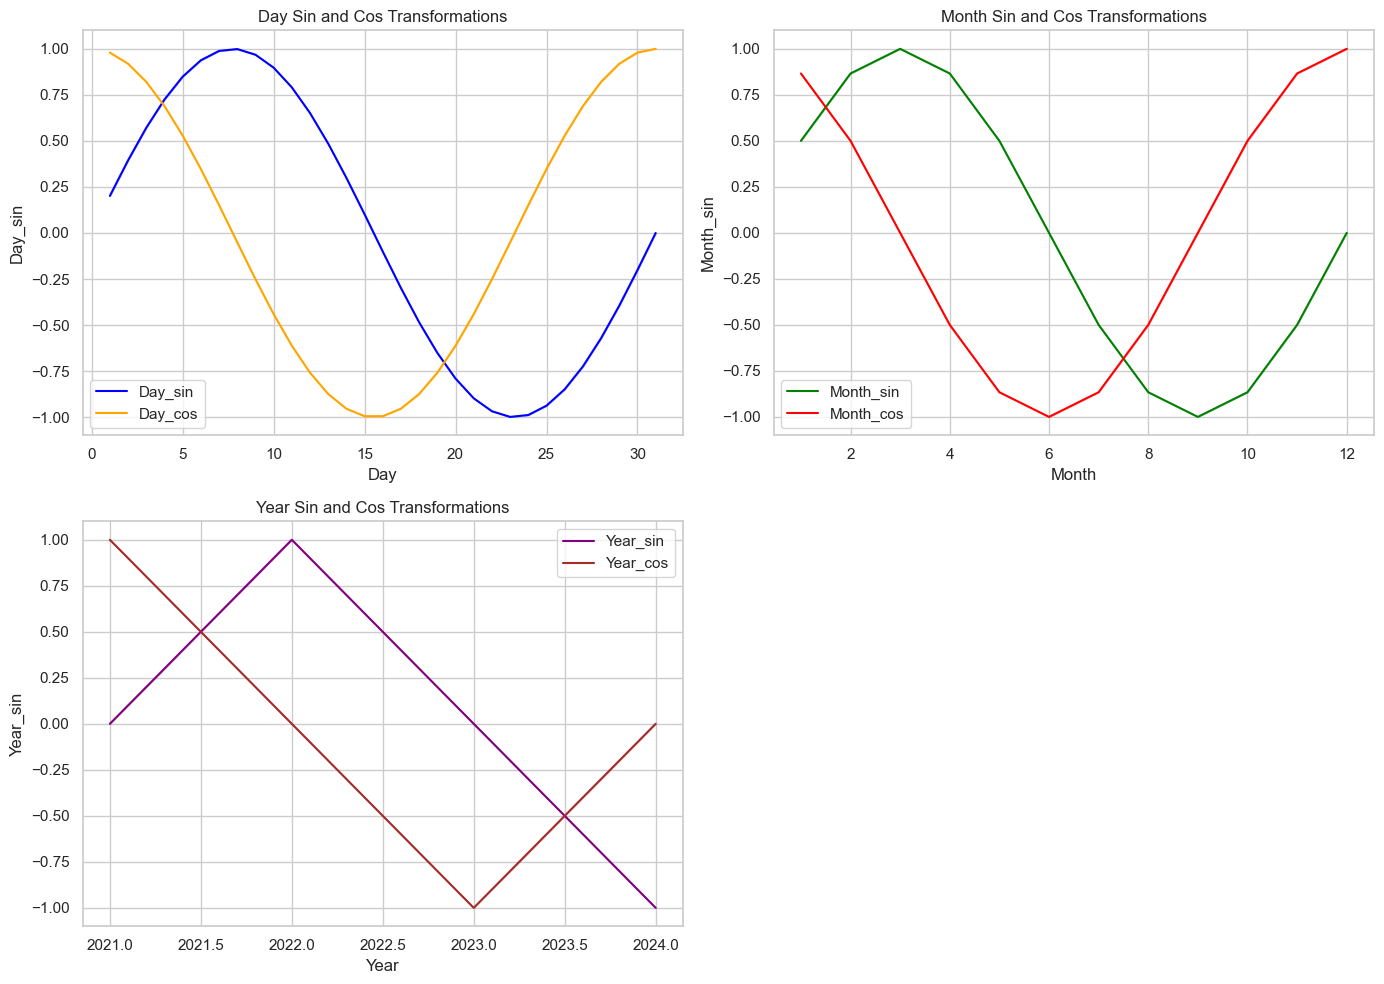

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure with subplots for each cyclical transformation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Day_sin and Day_cos
sns.lineplot(x=data['Day'], y=data['Day_sin'], ax=axes[0, 0], label='Day_sin', color='blue')
sns.lineplot(x=data['Day'], y=data['Day_cos'], ax=axes[0, 0], label='Day_cos', color='orange')
axes[0, 0].set_title('Day Sin and Cos Transformations')

# Plot Month_sin and Month_cos
sns.lineplot(x=data['Month'], y=data['Month_sin'], ax=axes[0, 1], label='Month_sin', color='green')
sns.lineplot(x=data['Month'], y=data['Month_cos'], ax=axes[0, 1], label='Month_cos', color='red')
axes[0, 1].set_title('Month Sin and Cos Transformations')

# Plot Year_sin and Year_cos
sns.lineplot(x=data['Year'], y=data['Year_sin'], ax=axes[1, 0], label='Year_sin', color='purple')
sns.lineplot(x=data['Year'], y=data['Year_cos'], ax=axes[1, 0], label='Year_cos', color='brown')
axes[1, 0].set_title('Year Sin and Cos Transformations')

# Hide the empty subplot
axes[1, 1].axis('off')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


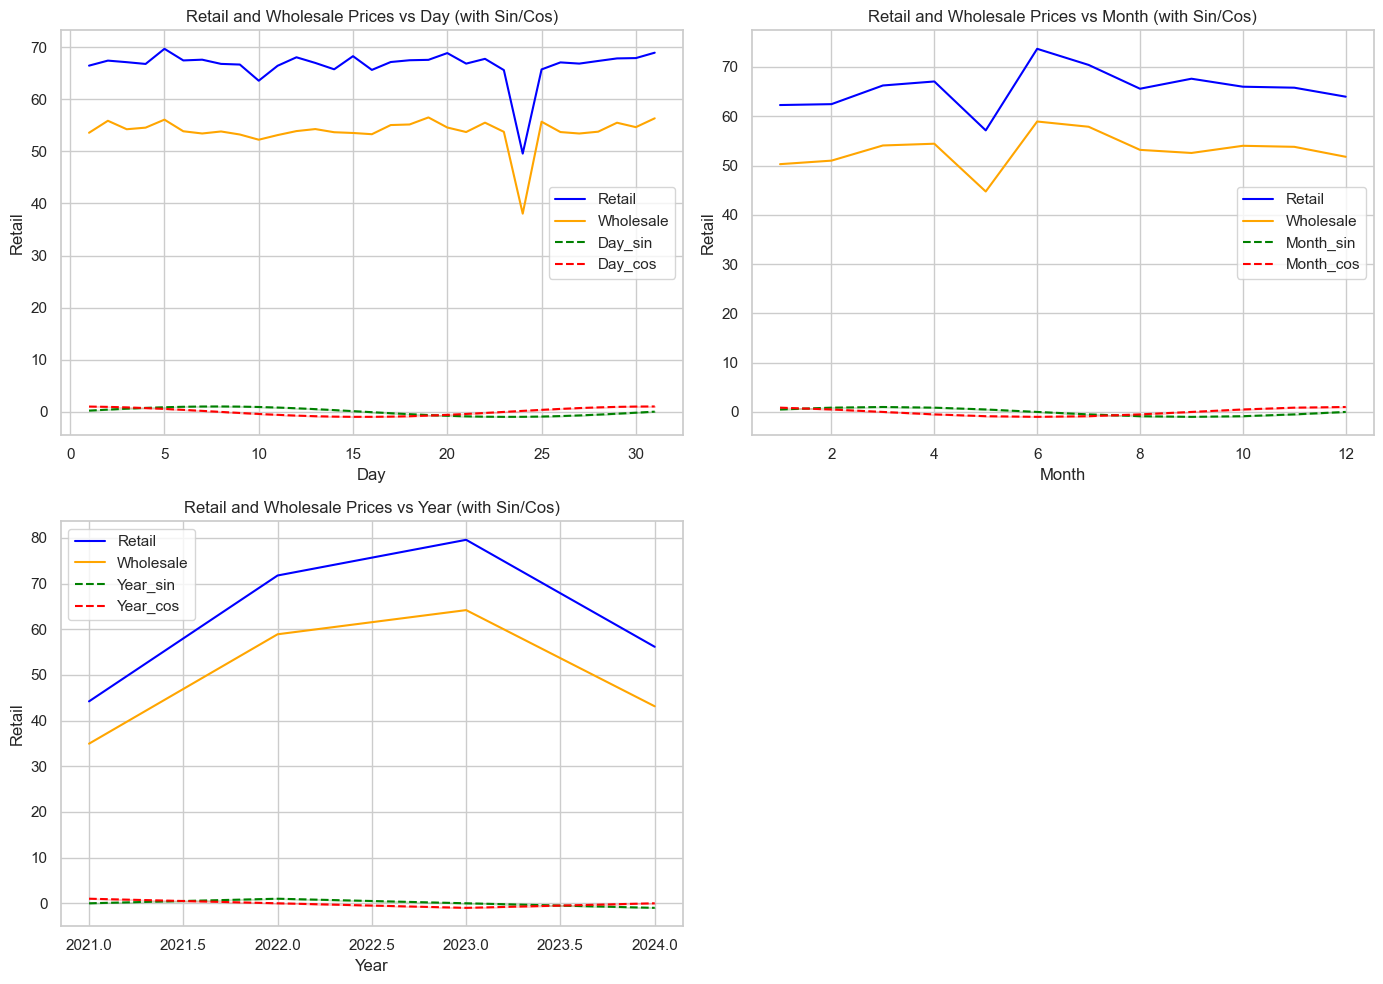

In [11]:
# Group by day, month, and year to calculate average retail and wholesale prices
day_agg = data.groupby('Day')[['Retail', 'Wholesale']].mean().reset_index()
month_agg = data.groupby('Month')[['Retail', 'Wholesale']].mean().reset_index()
year_agg = data.groupby('Year')[['Retail', 'Wholesale']].mean().reset_index()

# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure with subplots for each cyclical transformation and aggregate prices
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Day_sin and Day_cos with Retail and Wholesale
sns.lineplot(x=day_agg['Day'], y=day_agg['Retail'], ax=axes[0, 0], label='Retail', color='blue')
sns.lineplot(x=day_agg['Day'], y=day_agg['Wholesale'], ax=axes[0, 0], label='Wholesale', color='orange')
sns.lineplot(x=data['Day'], y=data['Day_sin'], ax=axes[0, 0], label='Day_sin', color='green', linestyle='--')
sns.lineplot(x=data['Day'], y=data['Day_cos'], ax=axes[0, 0], label='Day_cos', color='red', linestyle='--')
axes[0, 0].set_title('Retail and Wholesale Prices vs Day (with Sin/Cos)')

# Plot Month_sin and Month_cos with Retail and Wholesale
sns.lineplot(x=month_agg['Month'], y=month_agg['Retail'], ax=axes[0, 1], label='Retail', color='blue')
sns.lineplot(x=month_agg['Month'], y=month_agg['Wholesale'], ax=axes[0, 1], label='Wholesale', color='orange')
sns.lineplot(x=data['Month'], y=data['Month_sin'], ax=axes[0, 1], label='Month_sin', color='green', linestyle='--')
sns.lineplot(x=data['Month'], y=data['Month_cos'], ax=axes[0, 1], label='Month_cos', color='red', linestyle='--')
axes[0, 1].set_title('Retail and Wholesale Prices vs Month (with Sin/Cos)')

# Plot Year_sin and Year_cos with Retail and Wholesale
sns.lineplot(x=year_agg['Year'], y=year_agg['Retail'], ax=axes[1, 0], label='Retail', color='blue')
sns.lineplot(x=year_agg['Year'], y=year_agg['Wholesale'], ax=axes[1, 0], label='Wholesale', color='orange')
sns.lineplot(x=data['Year'], y=data['Year_sin'], ax=axes[1, 0], label='Year_sin', color='green', linestyle='--')
sns.lineplot(x=data['Year'], y=data['Year_cos'], ax=axes[1, 0], label='Year_cos', color='red', linestyle='--')
axes[1, 0].set_title('Retail and Wholesale Prices vs Year (with Sin/Cos)')

# Hide the empty subplot
axes[1, 1].axis('off')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


LSTM Models work with data with a specific shape, the shape is a 3D data frame with the following columns on the main axis samples, time steps, features

In [12]:
#Reshaping data
 
# Define time steps (e.g., last 7 records)
time_steps = 7

# Reshape X and y to fit LSTM input shape
def reshape_lstm_input(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps].values)
    return np.array(Xs), np.array(ys)

X_lstm, y_lstm = reshape_lstm_input(X, y, time_steps)

# Check the shape of the reshaped data
print(f"X shape: {X_lstm.shape}")  # Should be (samples, time_steps, features)
print(f"y shape: {y_lstm.shape}")  # Should be (samples, targets)


X shape: (21250, 7, 300)
y shape: (21250, 1)


In [13]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=30)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (17000, 7, 300)
Testing set shape: (4250, 7, 300)


In [14]:
# Custom percentage mean squared error (PMSE) loss function
def percentage_mean_squared_error(y_true, y_pred):
    return K.mean(K.square((y_true - y_pred) / y_true)) * 100

# Model Architecture
model = Sequential()

# First LSTM layer with return_sequences=True to pass the entire sequence to the next layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer with return_sequences=False to output only the final output
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer with 2 units (for predicting Retail and Wholesale prices)
model.add(Dense(units=1))




# Define a custom learning rate
learning_rate = 0.001  

# Create the Adam optimizer with the custom learning rate
adam_optimizer = Adam(learning_rate=learning_rate)

# Compile the model using the custom optimizer
model.compile(optimizer=adam_optimizer, loss="mse")

# Summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 50)             70200     
                                                                 
 dropout (Dropout)           (None, 7, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 90,451
Trainable params: 90,451
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
266/266 [==============================] - 17s 24ms/step - loss: 2402.2109 - val_loss: 1694.8048
Epoch 2/5
266/266 [==============================] - 4s 17ms/step - loss: 1508.9042 - val_loss: 1150.2203
Epoch 3/5
266/266 [==============================] - 4s 16ms/step - loss: 1121.8129 - val_loss: 890.4564
Epoch 4/5
266/266 [==============================] - 4s 16ms/step - loss: 951.1867 - val_loss: 787.2214
Epoch 5/5
266/266 [==============================] - 5s 18ms/step - loss: 886.4849 - val_loss: 753.5485


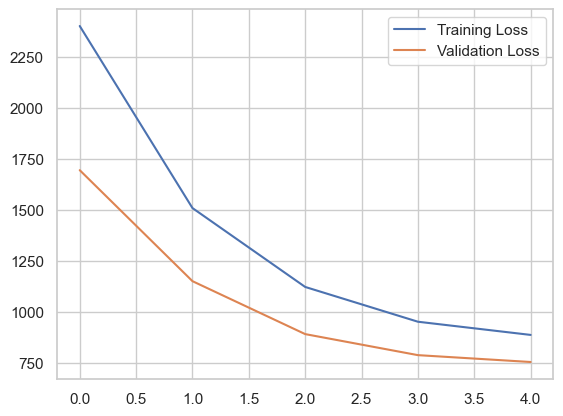

In [15]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), verbose=1)


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [16]:
# Evaluate the model on test data
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions
y_pred = model.predict(X_test)

# Compare predictions with actual values
print("Predicted Prices:", y_pred[:5])
print("Actual Prices:", y_test[:5])


133/133 [==============================] - 1s 10ms/step - loss: 753.5482
Test Loss: 753.5481567382812
133/133 [==============================] - 3s 5ms/step
Predicted Prices: [[49.23459 ]
 [49.234962]
 [49.23532 ]
 [49.236343]
 [49.236343]]
Actual Prices: [[30.   ]
 [44.334]
 [35.   ]
 [70.   ]
 [75.   ]]


In [17]:
modeling_data.columns

Index(['Wholesale', 'Retail', 'Supply Volume', 'Market_Ahero', 'Market_Akala',
       'Market_Amoni', 'Market_Amukura', 'Market_Aram',
       'Market_Athi River Open air Market', 'Market_Awendo',
       ...
       'County_test', 'Day', 'Month', 'Year', 'Day_sin', 'Day_cos',
       'Month_sin', 'Month_cos', 'Year_sin', 'Year_cos'],
      dtype='object', length=302)

In [18]:
# Features for LSTM model (including sin/cos time features and 'Supply Volume')
X_lstm = modeling_data[['Supply Volume', 'Day', 'Month', 'Year', 'Day_sin', 'Day_cos', 'Month_sin', 'Month_cos', 'Year_sin', 'Year_cos']].values

# One-hot encoded features for non-sequential input
X_non_seq = modeling_data.drop(['Supply Volume', 'Day', 'Month', 'Year', 'Day_sin', 'Day_cos', 'Month_sin', 'Month_cos', 'Year_sin', 'Year_cos', 'Wholesale', 'Retail'], axis=1)


# Target values (e.g., Wholesale and Retail prices)
y = modeling_data[['Wholesale', 'Retail']].values


In [19]:
# Reshape to 3D array for LSTM (samples, timesteps, features)
# Assuming each sample has 1 timestep (you can adjust the timestep based on your needs)
X_lstm = X_lstm.reshape((X_lstm.shape[0], 1, X_lstm.shape[1]))


In [20]:
# Split both sequential (LSTM) and non-sequential (one-hot encoded) data
X_lstm_train, X_lstm_test, X_non_seq_train, X_non_seq_test, y_train, y_test = train_test_split(
    X_lstm, X_non_seq, y, test_size=0.2, random_state=30
)


In [21]:
from tensorflow.keras.layers import Input, Concatenate, LSTM, Dropout, Dense
import tensorflow as tf

# Input for LSTM branch (sequential data)
lstm_input = Input(shape=(X_lstm_train.shape[1], X_lstm_train.shape[2]))

# LSTM layers for sequential data
x = LSTM(units=10, return_sequences=False)(lstm_input)  # Reduce units and keep only one LSTM layer
x = Dropout(0.2)(x)  # Keep dropout

# Dense layer to match the dimensions for concatenation
x = Dense(290)(x)  # Assuming `290` matches the number of features in non-sequential data

# Input for non-sequential data (one-hot encoded features)
non_seq_input = Input(shape=(X_non_seq_train.shape[1],))

# Concatenate LSTM and non-sequential branches
concatenated = Concatenate()([x, non_seq_input])

# Output layer
output = Dense(units=2)(concatenated)

# Define the model with two inputs
model = tf.keras.models.Model(inputs=[lstm_input, non_seq_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')  # Use a standard loss function

# Model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 10)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 10)           840         ['input_1[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 10)           0           ['lstm_2[0][0]']                 
                                                                                                  
 dense_1 (Dense)                (None, 290)          3190        ['dropout_2[0][0]']              
                                                                                              

In [22]:
# Train the model with both LSTM and non-sequential data
history = model.fit([X_lstm_train, X_non_seq_train], y_train, epochs=50, batch_size=30, validation_data=([X_lstm_test, X_non_seq_test], y_test), verbose=1)



Epoch 1/50
567/567 [==============================] - 9s 7ms/step - loss: 1795.0945 - val_loss: 1017.4920
Epoch 2/50
567/567 [==============================] - 2s 4ms/step - loss: 1099.1283 - val_loss: 982.0292
Epoch 3/50
567/567 [==============================] - 2s 4ms/step - loss: 1041.7809 - val_loss: 965.4178
Epoch 4/50
567/567 [==============================] - 2s 4ms/step - loss: 1015.7745 - val_loss: 957.9736
Epoch 5/50
567/567 [==============================] - 2s 4ms/step - loss: 1003.3207 - val_loss: 948.8804
Epoch 6/50
567/567 [==============================] - 2s 4ms/step - loss: 995.7570 - val_loss: 941.4818
Epoch 7/50
567/567 [==============================] - 3s 4ms/step - loss: 989.6138 - val_loss: 934.9045
Epoch 8/50
567/567 [==============================] - 2s 4ms/step - loss: 983.2802 - val_loss: 933.0999
Epoch 9/50
567/567 [==============================] - 2s 4ms/step - loss: 977.7724 - val_loss: 922.7581
Epoch 10/50
567/567 [==============================] - 2s 